In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.constants as ac
import astropy.units as au
import os,re
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200


In [3]:
from vtk_reader import *

In [4]:
def select_phase(temperature,density,phase='warm'):
    '''
        Select gas phase (setting density[~phase]=0)
        
        phase=['whole','warm','cold','2p','lowd']
        
    '''
    T1=5050.
    T2=2.e4
    dmax=50
    if phase is 'whole': 
        return density
    elif phase is 'warm':
        idx = (temperature < T1) | (temperature > T2)
    elif phase is 'cold': 
        idx = (temperature >= T1) 
    elif phase is '2p': 
        idx = (temperature > T2) 
    elif phase is 'lowd': 
        idx = (temperature > T2) | (density > dmax)
    else:
        print("{} is not supported".format(phase))
        return -1
    
    dnew = np.copy(density)
    dnew[idx] = 0.0

    return dnew

def setup_domain(fname, purpose='HI', shear=0):
    '''
        Setting up domain information for the data reader
        fields= [density, magnetic_field] for synthetic dust polarization 
            or  [density, velocity, temperature] for synthetic HI 21cm line
            
        Inputs
        ------
        fname: string
            vtk data dump file name
            
        Outputs
        -------
        ds: AthenaDataSet (pyathena class)
        
        domain: AthenaDomain (pyathena class)
        
        Parameters
        ----------
        purpose: string
            [dustpol, HI]
            set relevant data field names for type of synthetic observations
        
        shear: float
            shear frequency (km/s/kpc): S = q Omega = 28 for TIGRESS solar nbhd.
    '''
    dir, id, step, ext, mpi = parse_filename(fname)
    ds=AthenaDataSet(fname)

    domain=ds.domain
    fields=['density']
    if purpose == 'HI':
        fields.append('temperature')
        fields.append('velocity1')
        fields.append('velocity2')
        fields.append('velocity3')
    elif purpose == 'dustpol':
        fields.append('magnetic_field1')
        fields.append('magnetic_field2')
        fields.append('magnetic_field3')
    else:
        raise ValueError('purpose={} is not supported'.format(purpose))

    domain['fields']=fields
    domain['shear']=shear
    domain['step']=step

    return ds,domain


def read_data(ds,field,domain,vy0_subtract=False):
    '''
        Wrapper for an Athena vtk output reader (pyathena)
        
        Inputs
        ------
        ds: AthenaDataSet (pyathena class)
        
        field: string
            name of the data field to be read
            
        domain: AthenaDomain (pyathena class)
            domain information (including shear information)
        
        
        Parameters
        ----------
        vy0_substract: bool
            if True, background shear velocity will be subtracted
    '''
    if field is 'temperature':
        data=coolftn.get_temp(ds.read_all_data('T1'))
    elif field is 'velocity2':
        data = ds.read_all_data(field)
        if vy0_subtract:
            r3d,x3d,y3d,z3d=pos3d(domain)
            vy0=-domain['shear']*x3d
            data -= vy0
    else:
        data = ds.read_all_data(field)
    
    return data

def xyz_coord(domain):
    Nx = domain['Nx']
    le = domain['left_edge']
    re = domain['right_edge']
    cc = []
    for Nx_, le_, re_ in zip(Nx,le,re):
        xfc = np.linspace(le_,re_,Nx_+1) # face centered positions (Nx+1)
        xcc = 0.5*(xfc[1:]+xfc[:-1]) # cell centered positions
        cc.append(xcc)
    return cc


In [5]:
# currently, the data is downloadable at 
# http://tigress-web.princeton.edu/~changgoo/TIGRESS_example_data/GASKAP_HI/R8_8pc_rst.0300.vtk
fname='./R8_8pc_rst.0300.vtk'

In [6]:
# initialize domain and data class
ds,domain=setup_domain(fname,purpose='HI')

In [7]:
# read number density cube
# shape = (Nz, Ny, Nx)
nH = read_data(ds,'density',domain)
# read temperature
temp = read_data(ds,'temperature',domain)
# read z-velocity
vz = read_data(ds,'velocity3',domain)
print('Nz, Ny, Nx=',nH.shape)

Nz, Ny, Nx= (896, 128, 128)


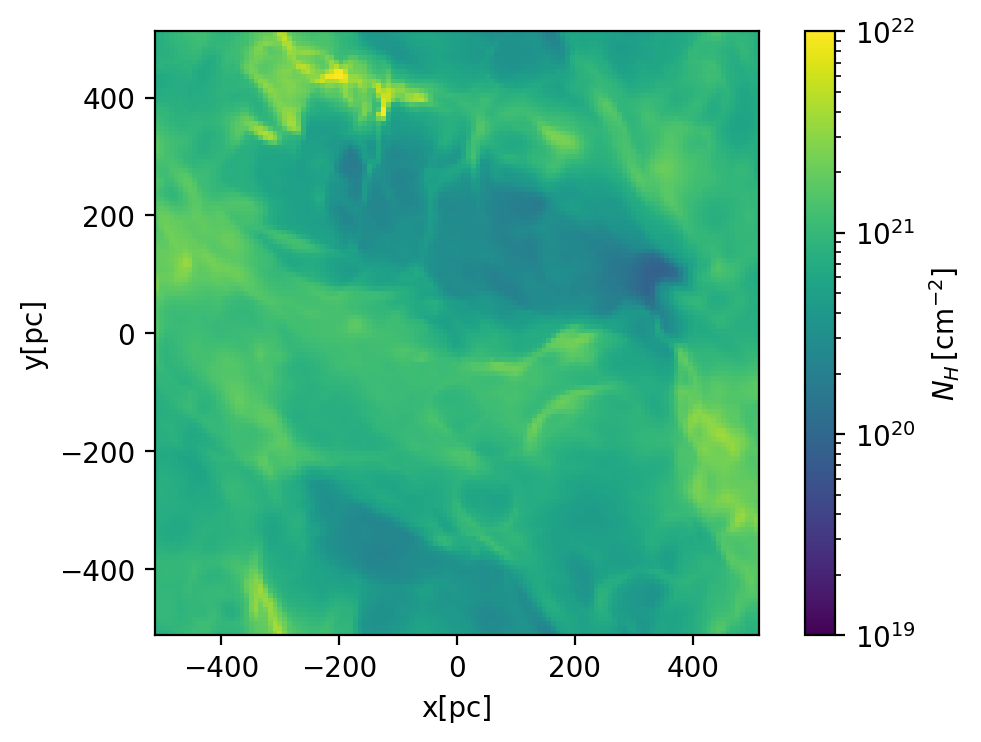

In [8]:
# projection along the z-axis

# find cell-centered positions
xcc,ycc,zcc = xyz_coord(domain)

# projection
dz = domain['dx'][2]*ac.pc
NH = nH.sum(axis=0)*dz.cgs.value

plt.pcolormesh(xcc,ycc,NH,norm=LogNorm(1.e19,1.e22),shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('y[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

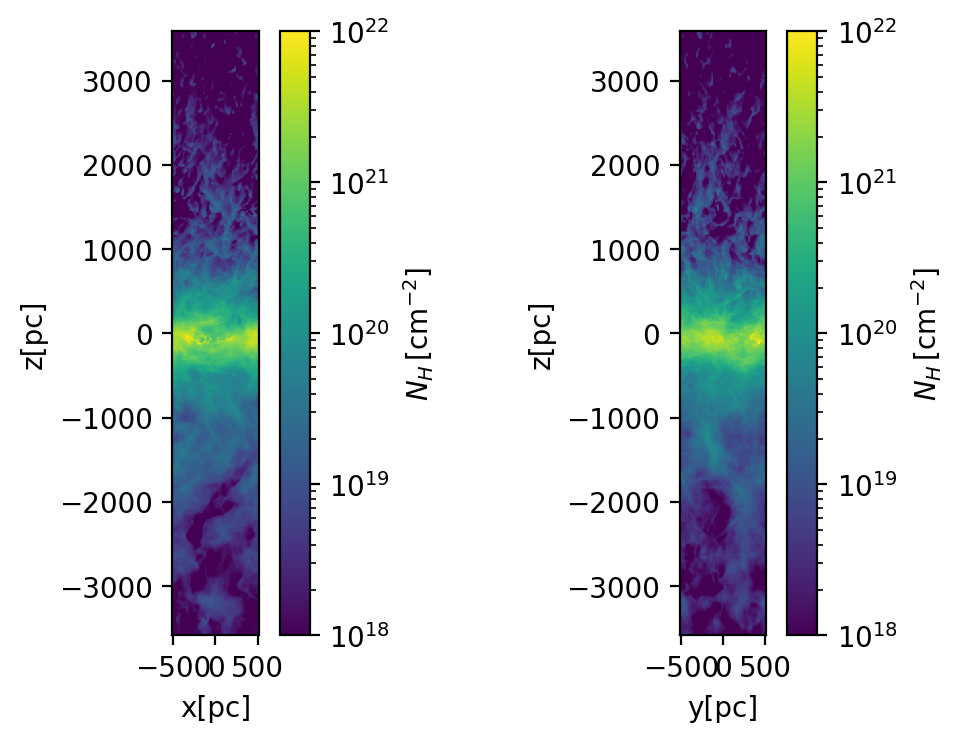

In [9]:
# projection along the x and y-axes
import astropy.constants as ac
import astropy.units as au
from matplotlib.colors import LogNorm

# find cell-centered positions
xcc,ycc,zcc = xyz_coord(domain)

# projection
dy = domain['dx'][1]*ac.pc
NHy = nH.sum(axis=1)*dy.cgs.value

dx = domain['dx'][0]*ac.pc
NHx = nH.sum(axis=2)*dx.cgs.value

plt.subplot(121)
plt.pcolormesh(xcc,zcc,NHy,norm=LogNorm(1.e18,1.e22),shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

plt.subplot(122)
plt.pcolormesh(ycc,zcc,NHx,norm=LogNorm(1.e18,1.e22),shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('y[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

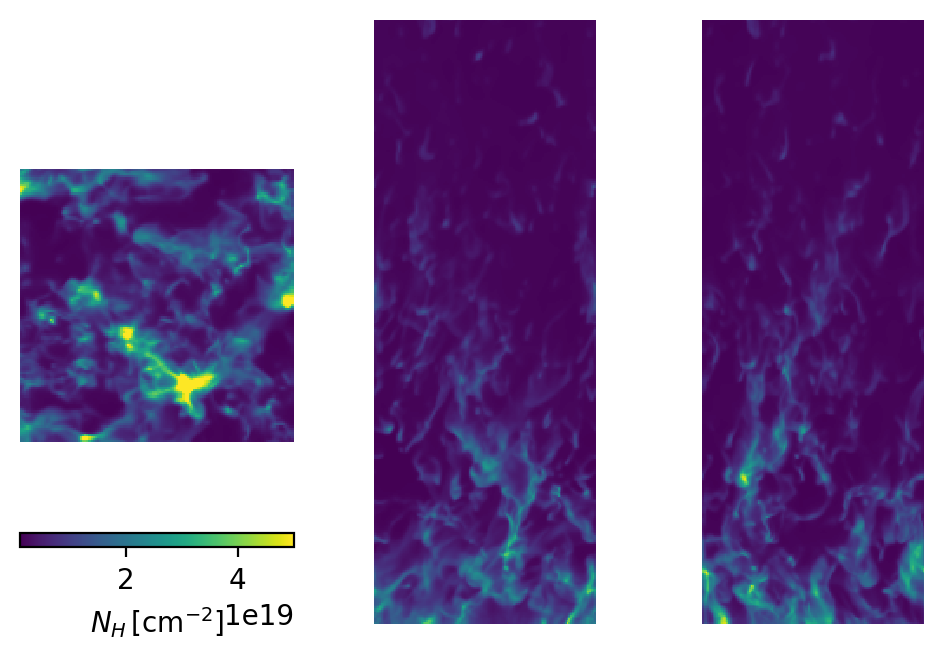

In [10]:
# cutout high-altitude region z>800pc
import astropy.constants as ac
import astropy.units as au
from matplotlib.colors import LogNorm

# find cell-centered positions
xcc,ycc,zcc = xyz_coord(domain)

# apply z-position cut
zcut = zcc>800

# projection
dz = domain['dx'][2]*ac.pc
NH = nH[zcut,:,:].sum(axis=0)*dz.cgs.value

dy = domain['dx'][1]*ac.pc
NHy = nH[zcut,:,:].sum(axis=1)*dy.cgs.value

dx = domain['dx'][0]*ac.pc
NHx = nH[zcut,:,:].sum(axis=2)*dx.cgs.value

for i,NH_,x_,y_ in zip(range(3),[NH,NHy,NHx],[xcc,xcc,ycc],[ycc,zcc[zcut],zcc[zcut]]):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(x_,y_,NH_,shading='nearest',vmax=5.e19)
    plt.gca().set_aspect('equal')
    plt.gca().axis('off')
    if i==0:
        cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$',orientation='horizontal')

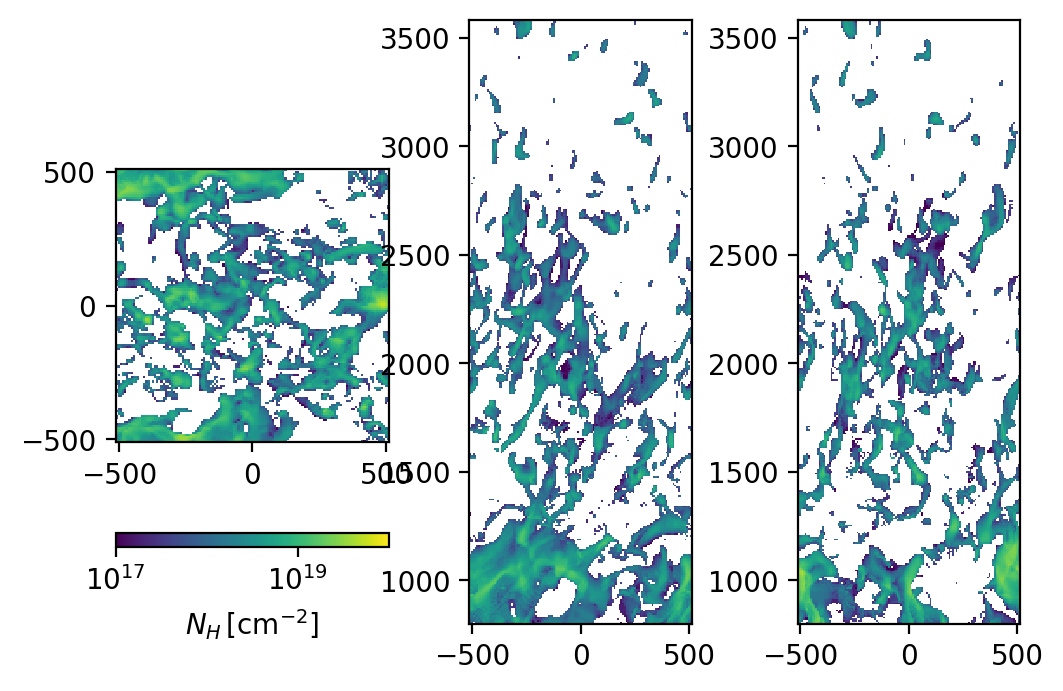

In [11]:
# find cell-centered positions
xcc,ycc,zcc = xyz_coord(domain)

# apply z-position cut
zcut = zcc>800
nH_ = nH[zcut,:,:]
temp_ = temp[zcut,:,:]
vz_ = vz[zcut,:,:]

# apply temperature and velocity cuts
tcut = temp_<1.5e4
vcut = vz_>30.
nH__ = nH_*tcut*vcut

dz = domain['dx'][2]*ac.pc
NH = nH__.sum(axis=0)*dz.cgs.value

dy = domain['dx'][1]*ac.pc
NHy = nH__.sum(axis=1)*dy.cgs.value

dx = domain['dx'][0]*ac.pc
NHx = nH__.sum(axis=2)*dx.cgs.value

for i,NH_,x_,y_ in zip(range(3),[NH,NHy,NHx],[xcc,xcc,ycc],[ycc,zcc[zcut],zcc[zcut]]):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(x_,y_,NH_,shading='nearest',norm=LogNorm(1.e17,1.e20))
    plt.gca().set_aspect('equal')
    if i==0:
        cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$',orientation='horizontal')

/Users/ckim/miniconda3/envs/synthetic/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'lw'
  del sys.path[0]


Text(0, 0.5, '$\\log\\,T$ [K]')

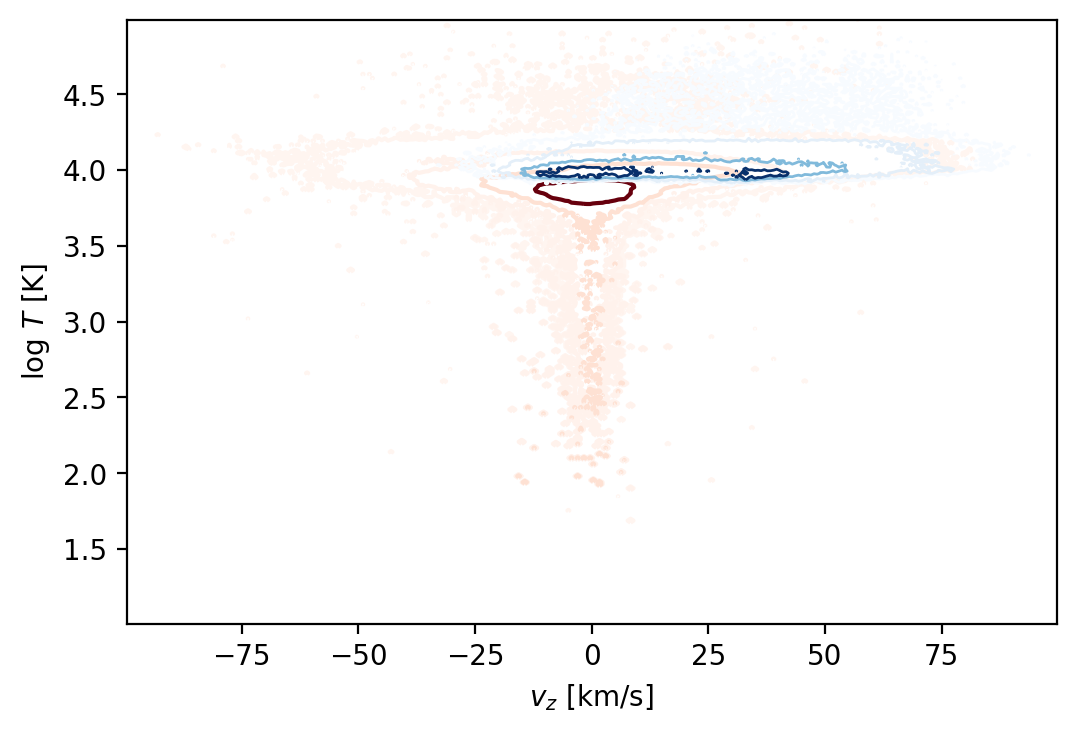

In [12]:
# Temperture-velocity distribution for full-box (reds) and upper regions (blues)
zcut = zcc>800
nH_ = nH[zcut,:,:]
temp_ = temp[zcut,:,:]
vz_ = vz[zcut,:,:]

h,b1,b2=np.histogram2d(np.log10(temp_.flatten()),vz_.flatten(),range=[[1,5],[-100,100]],bins=300,weights=nH_.flatten())
hall,b1,b2=np.histogram2d(np.log10(temp.flatten()),vz.flatten(),range=[[1,5],[-100,100]],bins=300,weights=nH.flatten())

percentiles = [68,86,95,99]
plt.contour(0.5*(b2[1:]+b2[:-1]),0.5*(b1[1:]+b1[:-1]),hall,
            levels=np.array([np.percentile(hall[hall!=0], p) for p in percentiles]),lw=2,
            cmap=plt.cm.Reds,
           )
plt.contour(0.5*(b2[1:]+b2[:-1]),0.5*(b1[1:]+b1[:-1]),h,
            levels=np.array([np.percentile(h[h!=0], p) for p in percentiles]),
            linewidths=[1],cmap=plt.cm.Blues,)
plt.xlabel(r'$v_z$ [km/s]')
plt.ylabel(r'$\log\,T$ [K]')

Text(0, 0.5, '$dM/dv$')

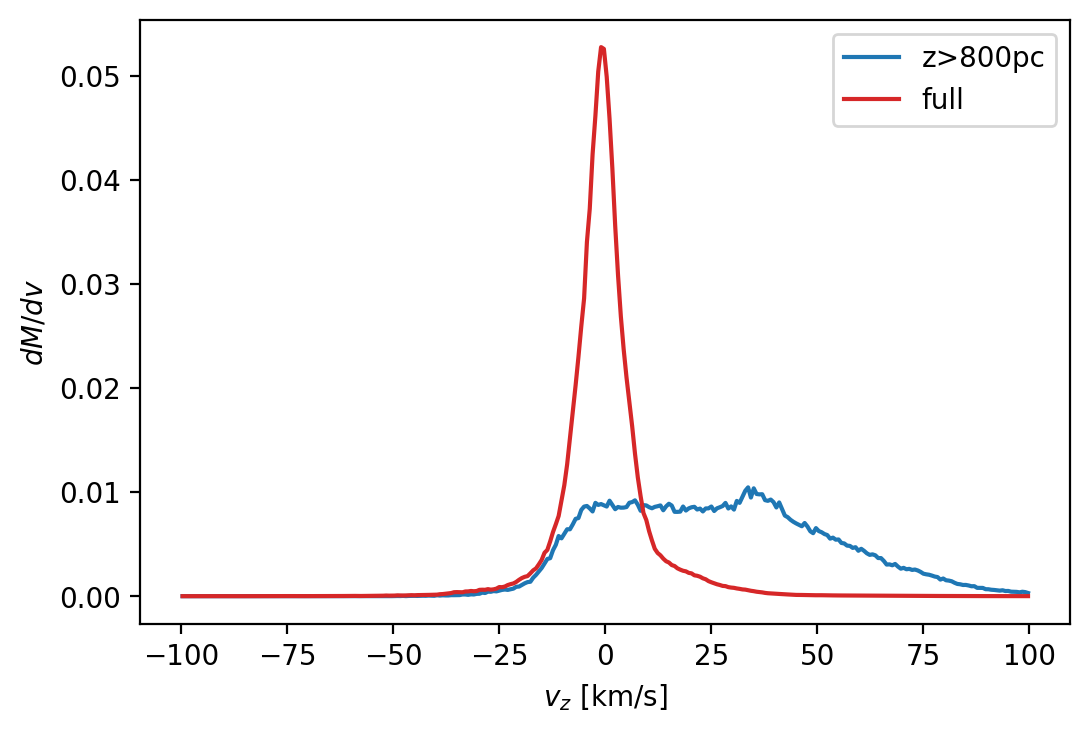

In [13]:
# velocity distribution for full-box (reds) and upper regions (blues)

plt.plot(0.5*(b2[1:]+b2[:-1]),h.sum(axis=0)/h.sum(),label='z>800pc')
plt.plot(0.5*(b2[1:]+b2[:-1]),hall.sum(axis=0)/hall.sum(),color='C3',label='full')
plt.legend()
plt.xlabel(r'$v_z$ [km/s]')
plt.ylabel(r'$dM/dv$')

# Synthetic HI

* Following the method presented in https://ui.adsabs.harvard.edu/abs/2014ApJ...786...64K/abstract
* Assuming that the WF effect is efficient enough to make T_spin = T_k based on Ly alpha radiation transfer study https://ui.adsabs.harvard.edu/abs/2020ApJS..250....9S/abstract
* $$N_H = 1.813\times10^{18}{\rm cm^{-2}}\int T_B \frac{\tau}{1-e^{-\tau}} d(v/(km/s))$$

In [14]:
import numpy as np

def los_to_HI_axis_proj(dens,temp,vel,vchannel,memlim=1.,
                        deltas=1.,los_axis=1,verbose=False):
    """
        inputs:
            dens: number density of hydrogen in units of 1/cm^3
            temp: temperature in units of K
            vel: line-of-sight velocity in units of km/s
            vchannel: velocity channel in km/s
        parameters:
            deltas: length of line segments in units of pc
            memlim: memory limit in GB
            los_axis: 0 -- z, 1 -- y, 2 -- x
        outputs: a dictionary
            TB: the brightness temperature
            tau: optical depth
    """
    
    Nv=len(vchannel)
    mem=np.prod(temp.shape)*8*Nv/1024.**3
    print(mem)
    if memlim>0:
        if mem>memlim:
            nchunk=int(mem/memlim)+1
            vchunk=[]
            dv=int(Nv/nchunk)+1
            if dv == 1:
                print("at least {} GB memory would be required".format(mem/Nv))
            for i in np.arange(nchunk):
                imin=i*dv
                imax=(i+1)*dv
                if imin>Nv:
                    break
                if imax>Nv:
                    vchunk.append(vchannel[imin:Nv])
                    break 
                vchunk.append(vchannel[imin:imax])
        Tlos=temp[np.newaxis,...]
        vlos=vel[np.newaxis,...]
        nlos=dens[np.newaxis,...]
    else:
        Tlos=temp
        vlos=vel
        nlos=dens

    Tspin=Tlos
    
    ds=deltas*3.085677581467192e+18

    v_L=0.21394414*np.sqrt(Tlos) # in units of km/s
    if mem>memlim:
        TB=[]
        tau_v=[]
        if memlim>0:
            for vch in vchunk:
                if verbose: print(vch)
                phi_v=0.00019827867/v_L*np.exp(-(1.6651092223153954*
                      (vch[:,np.newaxis,np.newaxis,np.newaxis]-vlos)/v_L)**2) # time
                kappa_v=2.6137475e-15*nlos/Tspin*phi_v # area/volume = 1/length
                tau_los=kappa_v*ds # dimensionless
        
                tau_cumul=tau_los.cumsum(axis=los_axis+1)
        
                TB.append(np.nansum(Tspin*(1-np.exp(-tau_los))*np.exp(-tau_cumul),axis=los_axis+1)) # same unit with Tspin
                tau_v.append(np.nansum(kappa_v*ds,axis=los_axis+1)) # dimensionless
            TB=np.concatenate(TB,axis=0)
            tau_v=np.concatenate(tau_v,axis=0)
        else:
            for vch in vchannel:
                if verbose: print(vch)
                phi_v=0.00019827867/v_L*np.exp(-(1.6651092223153954*
                      (vch-vlos)/v_L)**2) # time
                kappa_v=2.6137475e-15*nlos/Tspin*phi_v # area/volume = 1/length
                tau_los=kappa_v*ds # dimensionless
        
                tau_cumul=tau_los.cumsum(axis=los_axis)
        
                TB.append(np.nansum(Tspin*(1-np.exp(-tau_los))*np.exp(-tau_cumul),axis=los_axis)) # same unit with Tspin
                tau_v.append(np.nansum(kappa_v*ds,axis=los_axis)) # dimensionless
    else:
        phi_v=0.00019827867/v_L*np.exp(-(1.6651092223153954*
              (vchannel[:,np.newaxis,np.newaxis,np.newaxis]-vlos)/v_L)**2) # time
        kappa_v=2.6137475e-15*nlos/Tspin*phi_v # area/volume = 1/length
        tau_los=kappa_v*ds # dimensionless

        tau_cumul=tau_los.cumsum(axis=los_axis+1)

        TB=np.nansum(Tspin*(1-np.exp(-tau_los))*np.exp(-tau_cumul),axis=los_axis+1) # same unit with Tspin
        tau_v=np.nansum(kappa_v*ds,axis=los_axis+1) # dimensionless
 
    return np.array(TB),np.array(tau_v)


def k10h(T2):
    """
       input: T/100K
       output: collisional excitation rate of hydrogen in c.g.s.
    """
    k10_1=1.19e-10*T2**(0.74-0.20*np.log(T2))
    k10_2=2.24e-10*T2**0.207*np.exp(-0.876/T2)
    k10=k10_1
    idx=k10_2 > k10_1
    k10[idx]=k10_2[idx]
    return k10

def k10e(T2):
    """
       input: T/100K
       output: collisional excitation rate of electrion in c.g.s.
    """
    Temp=T2*1.e2
    k10=-9.607+0.5*np.log10(Temp)*np.exp(-(np.log10(Temp))**4.5/1.8e3)
    return 10.**k10

In [15]:
# Let's create synthetic HI along the z-direction seen from the top
# first, for the full data cube with only temperature cut

# apply temperature cut
zcut = zcc>-4000             # essentially no zcut
tcut = temp[zcut,:,:]<1.5e4  # select only possibly neutral gas
nlos = nH[zcut,:,:]*tcut     # setting density to zero for high-T gas
vlos = -vz[zcut,:,:]         # (-) sign as we are looking from the top
Tlos = temp[zcut,:,:] 

vch = np.linspace(-100,100,101) # velocity resolution of 1km/s
TB,tau = los_to_HI_axis_proj(nlos,Tlos,vlos,vch,memlim=2.,deltas=domain['dx'][2],
                             los_axis=0,verbose=True)

11.046875
[-100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.  -84.  -82.  -80.  -78.
  -76.  -74.  -72.  -70.  -68.]
[-66. -64. -62. -60. -58. -56. -54. -52. -50. -48. -46. -44. -42. -40.
 -38. -36. -34.]
[-32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.
  -4.  -2.   0.]
[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.]
[36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64. 66. 68.]
[ 70.  72.  74.  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.
  98. 100.]


In [16]:
# second, for the upper region with only temperature cut

# apply temperature cut
zcut = zcc>800               
tcut = temp[zcut,:,:]<1.5e4  # select only possibly neutral gas
nlos = nH[zcut,:,:]*tcut     # setting density to zero for high-T gas
vlos = -vz[zcut,:,:]         # (-) sign as we are looking from the top
Tlos = temp[zcut,:,:] 

vch = np.linspace(-100,100,101) # velocity resolution of 1km/s
TB_upper,tau_upper = los_to_HI_axis_proj(nlos,Tlos,vlos,vch,memlim=2.,deltas=domain['dx'][2],
                             los_axis=0,verbose=True)

4.29052734375
[-100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.  -84.  -82.  -80.  -78.
  -76.  -74.  -72.  -70.  -68.  -66.  -64.  -62.  -60.  -58.  -56.  -54.
  -52.  -50.  -48.  -46.  -44.  -42.  -40.  -38.  -36.  -34.]
[-32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.
  -4.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.
  24.  26.  28.  30.  32.  34.]
[ 36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.  62.
  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.  90.
  92.  94.  96.  98. 100.]


In [17]:
# save synthetic HI data to fits
from astropy.io import fits

def create_fits(domain):
    hdr = fits.Header()
    hdr['time']=domain['time']
    hdr['xmin']=(domain['left_edge'][0],'pc')
    hdr['xmax']=(domain['right_edge'][0],'pc')
    hdr['ymin']=(domain['left_edge'][1],'pc')
    hdr['ymax']=(domain['right_edge'][1],'pc')
    hdr['zmin']=(domain['left_edge'][2],'pc')
    hdr['zmax']=(domain['right_edge'][2],'pc')
    hdr['dx']=(domain['dx'][0],'pc')
    hdr['dy']=(domain['dx'][1],'pc')
    hdr['dz']=(domain['dx'][2],'pc')
    hdu = fits.PrimaryHDU(header=hdr)
    return hdu

def add_header_for_glue(hdu,hdr,axis='xyz'):
    for i,ax in enumerate(axis):
        hdu.header['CDELT{}'.format(i+1)]=hdr['d{}'.format(ax)]
        hdu.header['CTYPE{}'.format(i+1)]=ax
        hdu.header['CUNIT{}'.format(i+1)]=hdr.comments['d{}'.format(ax)]
        hdu.header['CRVAL{}'.format(i+1)]=hdr['{}min'.format(ax)]
        hdu.header['CRPIX{}'.format(i+1)]=hdr['{}max'.format(ax)]+hdr['{}min'.format(ax)]
    return 

def save_to_fits(domain,vchannel,TB,tau,fitsname=None):
    hdul = fits.HDUList()
    hdu = create_fits(domain)

    hdu.header['vmin']=(vchannel.min(),'km/s')
    hdu.header['vmax']=(vchannel.max(),'km/s')
    hdu.header['dv']=(vchannel[1]-vchannel[0],'km/s')

    hdul.append(hdu)
    for fdata,label in zip([TB,tau],['TB','tau']):
        hdul.append(fits.ImageHDU(name=label,data=fdata))

    hdr=hdu.header
    for hdu in hdul:
        add_header_for_glue(hdu,hdr,axis='xyv')

    if fitsname is not None: hdul.writeto(fitsname,overwrite=True)
    return hdul

In [18]:
fitsname = fname.replace('vtk','xy.HI.full.fits')
hdu = save_to_fits(domain,vch,TB,tau,fitsname)

In [19]:
fitsname = fname.replace('vtk','xy.HI.upper.fits')
hdu = save_to_fits(domain,vch,TB_upper,tau_upper,fitsname)

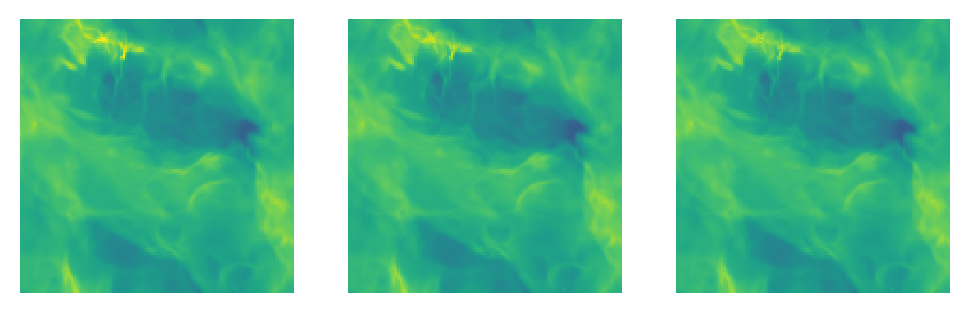

In [20]:
# projection
dz = domain['dx'][2]*ac.pc
NHsim = nH.sum(axis=0)*dz.cgs.value

dv = vch[1]-vch[0]
NHobs = 1.813e18*(TB*(tau+1.e-4)/(1-np.exp(-(tau+1.e-4)))).sum(axis=0)*dv
NHthin = 1.813e18*TB.sum(axis=0)*dv

for i,NH_ in zip(range(3),[NHsim,NHobs,NHthin]):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(xcc,ycc,NH_,shading='nearest',norm=LogNorm(1.e19,1.e22))
    plt.gca().set_aspect('equal')
    plt.gca().axis(False)
#     if i==0:
#         cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$',orientation='horizontal')

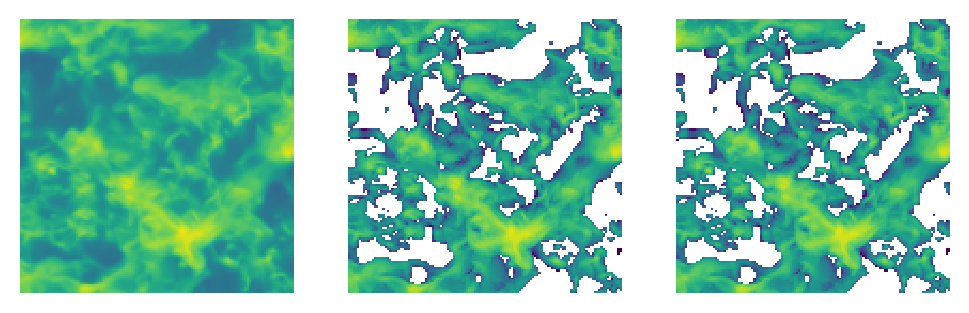

In [21]:
# projection
dz = domain['dx'][2]*ac.pc
zcut = zcc>800
nH_ = nH[zcut,:,:]
NHsim = nH_.sum(axis=0)*dz.cgs.value

dv = vch[1]-vch[0]
NHobs = 1.813e18*(TB_upper*(tau_upper+1.e-4)/(1-np.exp(-(tau_upper+1.e-4)))).sum(axis=0)*dv
NHthin = 1.813e18*TB_upper.sum(axis=0)*dv

for i,NH_ in zip(range(3),[NHsim,NHobs,NHthin]):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(xcc,ycc,NH_,shading='nearest',norm=LogNorm(1.e17,1.e20))
    plt.gca().set_aspect('equal')
    plt.gca().axis(False)
#     if i==0:
#         cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$',orientation='horizontal')

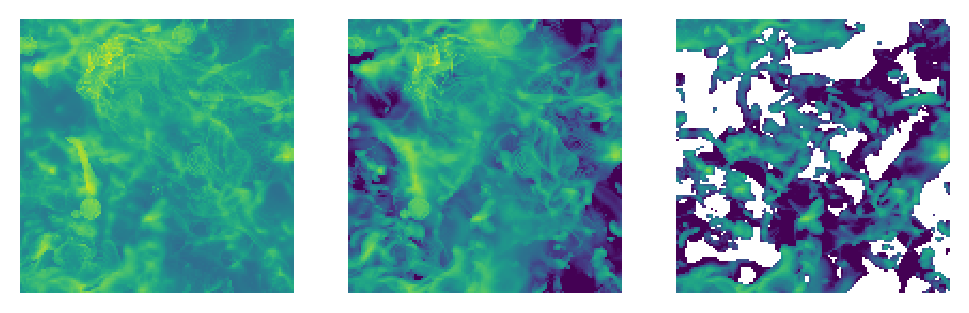

In [22]:
# projection: velocity cut
dz = domain['dx'][2]*ac.pc
vcut = vz>40
nH_ = nH*vcut
NHsim = nH_.sum(axis=0)*dz.cgs.value

dv = vch[1]-vch[0]
NH_full = 1.813e18*(TB*(tau+1.e-4)/(1-np.exp(-(tau+1.e-4))))*dv
NH_upper = 1.813e18*(TB_upper*(tau_upper+1.e-4)/(1-np.exp(-(tau_upper+1.e-4))))*dv
NH_full = NH_full[vch<-40,:,:].sum(axis=0)
NH_upper = NH_upper[vch<-40,:,:].sum(axis=0)

for i,NH_ in zip(range(3),[NHsim,NH_full,NH_upper]):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(xcc,ycc,NH_,shading='nearest',norm=LogNorm(1.e17,1.e20))
    plt.gca().set_aspect('equal')
    plt.gca().axis(False)


Evidently, there are a lot of gas at large blue-shifted velocities (v_z > 40km/s or v_los < -40km/s) from the opoosite side of the disk.